In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB == True:
    print("Colab used")
else : 
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = "5"

# Wildfire Segmentation with Multi-spectral Images - Bonus

### Try finding the best combination of loss/weight/epochs/architecture to get a test f1_score higher than 98%.

# 0.1 Get dataset files paths

In [2]:
# Imports
import os
import tensorflow as tf

# Dataset folder paths declaration
RGB_dir = "data/RGB"                    # Only for display purpose
triband_dir = "data/tribands"    # Data
target_dir = "data/masks"          # Labels

# Images parameters
img_size = (256, 256)

##############################################
# Get name of each file from XXXXX_dir folders
##############################################

def sort_tif_paths_from_folder(dir):
    paths_list = sorted(
    [
        os.path.join(dir, fname)
        for fname in os.listdir(dir)
        if fname.endswith(".tif")
    ]
    )
    return paths_list

RGB_img_paths = sort_tif_paths_from_folder(RGB_dir)

triband_img_paths_train =   sort_tif_paths_from_folder(triband_dir + "/train" )
triband_img_paths_val   =   sort_tif_paths_from_folder(triband_dir + "/val")
triband_img_paths_test  =   sort_tif_paths_from_folder(triband_dir + "/test")

target_img_paths_train  =   sort_tif_paths_from_folder(target_dir + "/train")
target_img_paths_val    =   sort_tif_paths_from_folder(target_dir + "/val")
target_img_paths_test   =   sort_tif_paths_from_folder(target_dir + "/test")

# Check the number of sample from triband_dir and target_dir
print("Number of samples from {} : {}".format(triband_dir, len(triband_img_paths_train)+len(triband_img_paths_val)+len(triband_img_paths_test)))
print("Number of samples from {} : {}".format(target_dir, len(target_img_paths_train)+len(target_img_paths_val)+len(target_img_paths_test)))

# 6 firsts paths from RGB, biband and target paths
# note : only works for the 15 first because we don't have much RGB images
for RGB_path, triband_path, target_path in zip(RGB_img_paths[:6], triband_img_paths_train[:6], target_img_paths_train[:6]):
    print(RGB_path, "|", triband_path, "|", target_path)

##############################################
##############################################

Number of samples from data/tribands : 1685
Number of samples from data/masks : 1685
data/RGB/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_0.tif | data/tribands/train/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_0.tif | data/masks/train/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_0.tif
data/RGB/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_1.tif | data/tribands/train/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_1.tif | data/masks/train/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_1.tif
data/RGB/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_10.tif | data/tribands/train/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_10.tif | data/masks/train/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_10.tif
data/RGB/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_11.tif | data/tribands/train/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_11.tif | data/masks/train/_Senti

First we import a function to display several images (declared in /utils.py) and others utils

In [3]:
from utils import display_matrix

# Used to load/Read/ and plot images 
import matplotlib.pyplot as plt

# Used to perform manipulation on matrix/images
import numpy as np


# 0.3 Load dataset

In [4]:
import PIL
from PIL import Image

batch_size = 16

def load_triband_and_target_from_paths(paths = None):
    x = np.zeros((len(paths),) + img_size + (3,), dtype="float32")
    y = np.zeros((len(paths),) + img_size + (1,), dtype="float32")
    for i, (in_path, targ_path)  in enumerate(paths):
        input = np.array(Image.open(in_path))/255.0
        x[i] = input
        out = np.array(Image.open(targ_path))
        out = np.expand_dims(out, 2)
        y[i] = out
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    data = data.map(lambda x, y: (x , y))
    return data

In [5]:
train_paths = list(zip(triband_img_paths_train, target_img_paths_train))
val_paths = list(zip(triband_img_paths_val, target_img_paths_val))
test_paths = list(zip(triband_img_paths_test, target_img_paths_test))


train_ds =  load_triband_and_target_from_paths(train_paths)
val_ds = load_triband_and_target_from_paths(val_paths)
test_ds = load_triband_and_target_from_paths(test_paths)

2023-01-26 13:40:08.478932: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 13:40:09.200562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10413 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:8c:00.0, compute capability: 6.1


# 0.4 Declaration of all loss, metrics etc...

In [27]:
from metrics_and_losses import recall_m, precision_m, f1_m

# Import a predict function similar to model.predict but with a treshhold at 0.5 (see utils.py)
from utils import predict

# A function that display firsts n_range tri-bands, masks and predictions
def display_sample_prediction(model, triband_paths, target_paths, n_range = 6): 
  # Pass through n_range firsts images 
  for n in range(n_range) :
    
    # Read Tri-band and mask
    n_triband = np.array(plt.imread(triband_paths[n]))/255.0
    n_mask = plt.imread(target_paths[n])
    
    # If there is one or more "Fire" pixel
    # Display RGB, Tri-bands and Mask datas
    if np.max(n_mask) > 0:
      mask = n_mask
      
      tribands = np.expand_dims(n_triband, 0)
      
      predicted_mask = predict(model, tribands)
      predicted_mask = np.squeeze(predicted_mask)

      matrix=[[n_triband, mask, predicted_mask]] # [[Tribands,mask,predict]]

      display_matrix(matrix ,title_list=['Tri-bands', 'GT Mask', 'Predicted'])
      
from tensorflow.keras import backend as K


def weighted_binary_crossentropy( y_true, y_pred) :
        y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
        logloss = -(y_true * K.log(y_pred) * ones_weight + (1 - y_true) * K.log(1 - y_pred) * zeros_weight )
        return K.mean( logloss, axis=-1)

# The Dice loss function we will use in the model.compile
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def weighted_binary_crossentropy_and_dice(y_true, y_pred):
    return weighted_binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


# 1.1 Build the model

Here you will find the same base model used in the TP

In [24]:
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Flatten, Dense, UpSampling2D
from tensorflow.keras.optimizers import Adam
model = None

model = Sequential()

model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(Conv2D(4, (3, 3), activation='relu'))

model.add(Conv2DTranspose(4, (3, 3), activation='relu'))
model.add(Conv2DTranspose(8, (3, 3), activation='relu'))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 8)       224       
                                                                 
 conv2d_13 (Conv2D)          (None, 252, 252, 4)       292       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 254, 254, 4)      148       
 ranspose)                                                       
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 256, 256, 8)      296       
 ranspose)                                                       
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 1)       73        
                                                                 
Total params: 1,033
Trainable params: 1,033
Non-traina

# 1.2 Train the model

In [28]:
####
# If weighted_binary_crossentropy used
ones_weight = 26.0
zeros_weight = 1.0
####

metrics = [tf.keras.metrics.BinaryAccuracy(), recall_m, precision_m, f1_m]

model.compile(optimizer = Adam(learning_rate=0.01), metrics = metrics, loss = weighted_binary_crossentropy)

batch_size = 16
history = model.fit(train_ds, epochs = 4, validation_data = val_ds, batch_size=batch_size)

Epoch 1/4
64/64 [==============================] - 4s 43ms/step - loss: 0.0107 - binary_accuracy: 0.9988 - recall_m: 0.9612 - precision_m: 0.5616 - f1_m: 0.7017 - val_loss: 0.0056 - val_binary_accuracy: 0.9993 - val_recall_m: 0.9633 - val_precision_m: 0.6088 - val_f1_m: 0.7440
Epoch 2/4
64/64 [==============================] - 3s 40ms/step - loss: 0.0061 - binary_accuracy: 0.9990 - recall_m: 0.9705 - precision_m: 0.6039 - f1_m: 0.7401 - val_loss: 0.0047 - val_binary_accuracy: 0.9994 - val_recall_m: 0.9661 - val_precision_m: 0.6524 - val_f1_m: 0.7772
Epoch 3/4
64/64 [==============================] - 3s 39ms/step - loss: 0.0049 - binary_accuracy: 0.9991 - recall_m: 0.9773 - precision_m: 0.6351 - f1_m: 0.7658 - val_loss: 0.0040 - val_binary_accuracy: 0.9994 - val_recall_m: 0.9724 - val_precision_m: 0.6779 - val_f1_m: 0.7975
Epoch 4/4
64/64 [==============================] - 3s 40ms/step - loss: 0.0043 - binary_accuracy: 0.9992 - recall_m: 0.9799 - precision_m: 0.6518 - f1_m: 0.7790 - val

# 1.3 Evaluate the model 

In [29]:
from utils import print_score

model_score = model.evaluate(test_ds)
print_score(model_score)

21/21 [==============================] - 1s 14ms/step - loss: 0.0046 - binary_accuracy: 0.9994 - recall_m: 0.9788 - precision_m: 0.7218 - f1_m: 0.8296
|loss : 0.004606036003679037||Accuracy : 0.9994176030158997||Recall : 0.9787542223930359||Precision : 0.7218438386917114||f1_score : 0.8295636177062988|

# 1.4 Display predictions

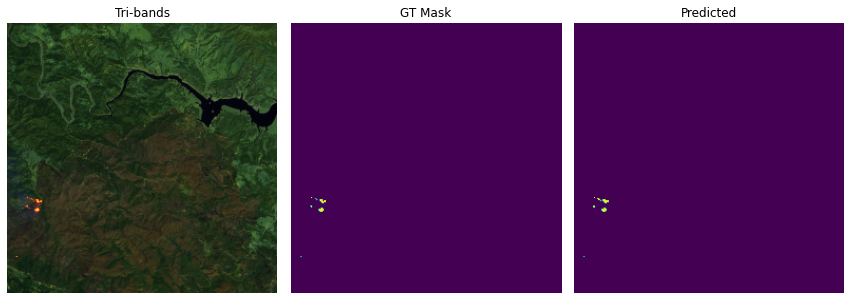

In [16]:
# Diplay Tri-bands, mask and prediction
display_sample_prediction(model, triband_img_paths_test, target_img_paths_test, n_range = 3)

# 1.5 Track your tests if you want !  

| test n°       | 0     | 1     | 2     | 3     | 4     | 5     | 6     | 7     | 8     | 9     | 10    | ...   | 
| ---           | ---   | ---   | ---   | ---   | ---   | ---   | ---   | ---   | ---   | ---   | ---   | ---   |
| f1_score      | 0.83  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| recall        | 0.97  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| precision     | 0.72  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| epochs        | 4     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| batch_size    | 16    | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| learning rate | 0.01  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| loss          | Dice  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| class weight  | None  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| n conv2d      | 3     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| n conv2dT     | 2     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| n params      | 1033  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |